## Import everything:
Ignore the complaints that wget and/or Poppy are not installed.

In [1]:
import simmetis as sm
from astropy import units as u
%pylab inline

Package wget is not available. simmetis.get_extras() will not work.


/Users/koehler/METIS/SimMETIS/simmetis/psf.py:125: UserWarning: Poppy is not installed. Functions beginning with "poppy_"
                  will not work. See http://pythonhosted.org/poppy/
  will not work. See http://pythonhosted.org/poppy/""")


Populating the interactive namespace from numpy and matplotlib


## Load the input and config files to create a simulator instance.
Adjust the paths to point to the files on your system.
Also make sure that the config file contains the correct SIM_DATA_DIR.

In [2]:
lms = sm.spectro.LMS("../../LMSsim/LINE_3D_013.fits", "metis_spectro_LMS.config")

Source file  ../../LMSsim/LINE_3D_013.fits
201 x 201 pixels, 251 spectral channels
image pixscale: [4.01736511 4.01736511] mas per pixel
BUNIT: JY/PIXEL
Pixel area is 1.6139222426878185e-05 arcsec2
CTYPES: ['RA---SIN', 'DEC--SIN', 'FREQ']
Wavelengths: [4.79232483 4.79233122 4.79233761] um ... 4.793923642827597 um
restfrq: 62546358407090.0
restwav: 0.0
Source velocities (WCS): -49991.66226419067 m / s ... 50008.34051741877 m / s
new naxis3: 67
Detector velocities: (67,) -49491.66087338595 ... 49508.33912661405
Reading config  metis_spectro_LMS.config
Detector pixel scale  8.200000000000001  mas/pixel
Filter =  ../data/TC_filter_open.dat


## Simulate what happens to the data cube on the way through the atmosphere, the telescope, and METIS:
This will take a while...

Do not skip any of the steps or change the order!


--------------------Transmission and Emission--------------------


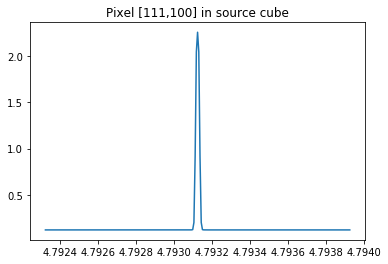

Reading  ../data/skycal_R308296_best_conditions.fits
Index skytran to src-wave: 483105 ... 483207
Steaming up optical train
Telescope temperature: -15.0


/Users/koehler/METIS/SimMETIS/simmetis/psf.py:1200: UserWarning: CDELT > 1. Assuming the scale to be [mas]
  warnings.warn("CDELT > 1. Assuming the scale to be [mas]")
/Users/koehler/miniconda3/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


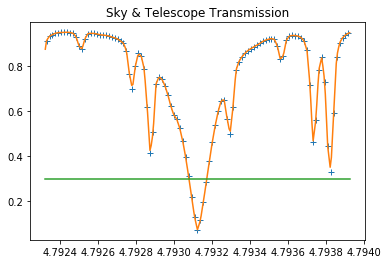

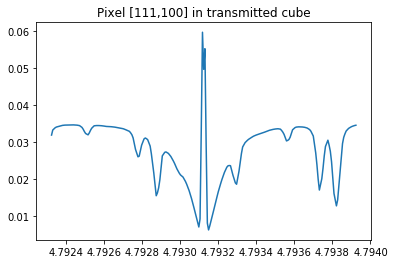

Pix_res:  0.0082
Mirror area:  1037.3460402337157 [m^2]


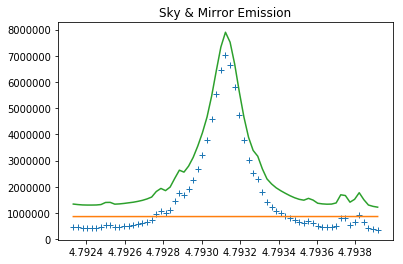

Final telescope temperature: -15.0

--------------------Convolution with PSF--------------------
image pixscale from WCS: [4.01736511 4.01736511] mas / pixel
Reading PSF ../data/PSF_SCAO_9mag_06seeing.fits
PSF for 3.8um is extension 2
PSF pixel scale is 7.65457 mas/pix @ 3.8 um, (1024, 1024) pixels
PSF pixel scale is 9.655080079899458 mas/pix @ 4.7931241472242 um,
Scale factor 2.4033364694476194
scale_image: old shape = (1024, 1024)
scale_image: new shape = (2460, 2460)
Normalizing PSF by factor 1115203631483117.5
Cropping PSF to [ 1029 : 1432 , 1029 : 1432 ]
Convolving with PSF...
       
--------------------Convolution with LSF--------------------
step in wavelen: 6.395256595485677e-06
step in velocity: 400.000007388017 m / s
deltav = 400.000007388017 m / s => stddev = 3.1849566922537855 pixel


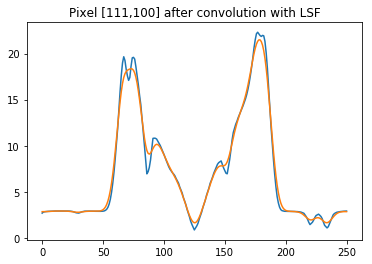


ScaleToDetector: naxis = 201 201 67
image pixscale from WCS: [4.01736511 4.01736511] mas /pixel
Scale factor: [0.48992257 0.48992257]
ScaleToDetector: new shape = (67, 99, 99)


In [3]:
lms.transmission_emission(conditions='best', plot=True)
lms.convolve_psf("PSF_SCAO_9mag_06seeing.fits", plot=True)
lms.convolve_lsf(plot=True)
lms.scale_to_detector()

## Compute the output cube:
By default, the total integration time and number of DITs is taken from the config file.

Source peak: 1460834280581.7346 ph / (arcsec2 s um)
(67, 99, 99)
Background max: 7898838.408741796 ph / (s um)
d_lambda 2.401661485426695e-05 um
Pixel area 6.724000000000001e-05 arcsec2
peak pos: (47, 49, 50)
Source peak: 2359.0679475648258 ph / s
Background:  189.70335985884253 ph / s


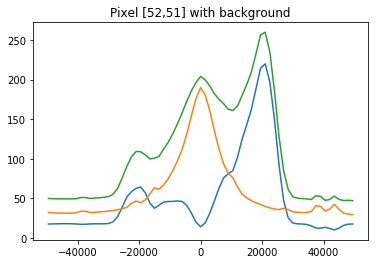

Exptime 60.0 s, NDIT = 2.0 , using DIT 30.0 s
Peak in one DIT 71968.7727821227 ph


In [4]:
result = lms.compute_snr(plot=True)

#### The result is an HDU object, i.e. you can write it to a FITS file, or access its data and header:

In [6]:
result.writeto("Test_output.fits", overwrite=True)
cube = result.data
cube.shape
print(result.header['HIERARCH SCOPE_TEMPERATURE'])

-15.0


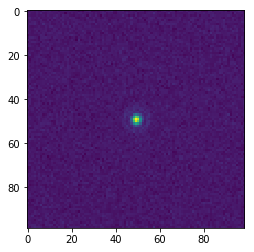

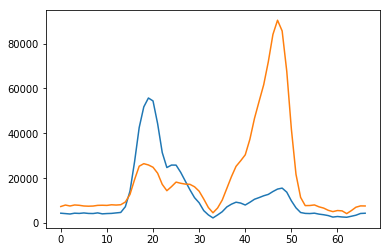

In [7]:
plt.figure()
plt.imshow(cube[33,:,:])

plt.figure()
plt.plot(cube[:,50,47])
plt.plot(cube[:,50,51])

## The last simulation step can be repeated with a different integration time:

In [11]:
result = lms.compute_snr(exptime=600., ndit=20)

Source peak: 1460834280581.7346 ph / (arcsec2 s um)
(67, 99, 99)
Background max: 7898838.408741796 ph / (s um)
d_lambda 2.401661485426695e-05 um
Pixel area 6.724000000000001e-05 arcsec2
peak pos: (47, 49, 50)
Source peak: 2359.0679475648258 ph / s
Background:  189.70335985884253 ph / s
Exptime 600.0 s, NDIT = 20 , using DIT 30.0 s
Peak in one DIT 71968.7727821227 ph


600.0


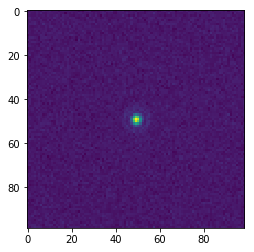

In [14]:
print(result.header['HIERARCH OBS_EXPTIME'])

plt.figure()
plt.imshow(cube[33,:,:])
